In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ga
from ga import *
from tradingrule import *

### Genetic Algo

In [12]:
# GA
import numpy as np
import matplotlib.pyplot as plt

def cal_pop_fitness(equation_inputs, pop):
    # Calculating the fitness value of each solution in the current population.
    # The fitness function calulates the sum of products between each input and its corresponding weight.
    # fitness = np.sum(pop*equation_inputs, axis=1)
    # pop size (8,6)
    # fitness size 8x1
    logr = equation_inputs[:,0]
    temp = pop@equation_inputs[:,1:7].T
    fitness = np.sum(temp*logr, axis = 1)/np.sum(pop, axis = 1)
    return fitness

def select_mating_pool(pop, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
    return parents

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    # The point at which crossover takes place between two parents. Usually, it is at the center.
    crossover_point = np.uint8(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover, num_mutations=1):
    mutations_counter = np.uint8(offspring_crossover.shape[1] / num_mutations)
    # Mutation changes a number of genes as defined by the num_mutations argument. The changes are random.
    for idx in range(offspring_crossover.shape[0]):
        gene_idx = mutations_counter - 1
        for _ in range(num_mutations):
            # The random value to be added to the gene.
            random_value = np.random.uniform(-1.0, 1.0, 1)
            offspring_crossover[idx, gene_idx] = offspring_crossover[idx, gene_idx] + random_value
            gene_idx = gene_idx + mutations_counter
    return offspring_crossover

def cal_pop_fitness(equation_inputs, pop, opt = 0):
    # Calculating the fitness value of each solution in the current population.
    # Opt = 0 is the GAMSSR model
    logr = equation_inputs[:,0] # n,
    positions = pop@equation_inputs[:,1:].T
    port_r = (positions*logr).astype(np.float64)
    SSR = np.mean(port_r, axis = 1)/np.std(port_r, axis = 1)/(-np.sum(port_r[port_r<0]))
    return SSR

def GA_train(training_df, optimizing_selection=0, sol_per_pop=8, num_parents_mating=4, num_generations = 200):
    """
    Genetic algorithm parameters:
        Mating pool size
        Population size
    """
    #Inputs of the equation.
    equation_inputs = training_df.values
    # Number of the weights we are looking to optimize.
    num_weights = training_df.shape[1]-1

    # Defining the population size.
    pop_size = (sol_per_pop,num_weights) 
    # The population will have sol_per_pop chromosome 
    # where each chromosome has num_weights genes.
    
    # Creating the initial population.
    new_population = np.random.uniform(low=-1.0, high=1.0, size=pop_size)
    # print(new_population)

    best_outputs = []
    
    for generation in range(num_generations):
    #     print("Generation : ", generation)
        # Measuring the fitness of each chromosome in the population.
        fitness = cal_pop_fitness(equation_inputs, new_population, optimizing_selection)

        best_outputs.append(np.max(fitness))

        # Selecting the best parents in the population for mating.
        parents = ga.select_mating_pool(new_population, fitness, 
                                          num_parents_mating)

        # Generating next generation using crossover.
        offspring_crossover = ga.crossover(parents,
                                           offspring_size=(pop_size[0]-parents.shape[0], num_weights))

        # Adding some variations to the offspring using mutation.
        offspring_mutation = ga.mutation(offspring_crossover, num_mutations=2)

        # Creating the new population based on the parents and offspring.
        new_population[0:parents.shape[0], :] = parents
        new_population[parents.shape[0]:, :] = offspring_mutation

    # Getting the best solution after iterating finishing all generations.
    # At first, the fitness is calculated for each solution in the final generation.
    fitness = cal_pop_fitness(equation_inputs, new_population, optimizing_selection)
    # Then return the index of that solution corresponding to the best fitness.
    best_match_idx = np.where(fitness == np.max(fitness))
        
    plt.plot(best_outputs)
    plt.xlabel("Iteration")
    plt.ylabel('SSR ratio')
    plt.show()
    return new_population[best_match_idx]

### Data preprocessing

In [2]:
data = pd.read_csv("data/AUDUSD_M5.csv")
data = data[['Open', 'High', 'Low', 'Close']]
data.head()

,Open,High,Low,Close
0,0.70613,0.70613,0.70575,0.70575
1,0.70575,0.70579,0.70568,0.70579
2,0.70579,0.70598,0.70578,0.70595
3,0.70596,0.70618,0.70594,0.70618
4,0.70618,0.70628,0.70593,0.70595


In [3]:
X_train = data.loc[:len(data)//2]
X_test = data.loc[len(data)//2:]

In [4]:
trading_rule_params = trainTradingRuleFeatures(X_train)

Training Rule1 score is: 0.422
Training Rule2 score is: 0.422
Training Rule3 score is: 0.451
Training Rule4 score is: 0.423
Training Rule5 score is: 0.401
Training Rule6 score is: 0.447
Training Rule7 score is: 0.453
Training Rule8 score is: 0.370
Training Rule9 score is: 0.452
Training Rule10 score is: 0.460
Training Rule11 score is: 0.363
Training Rule12 score is: 0.457
Training Rule13 score is: 0.363
Training Rule14 score is: 0.239
Training Rule15 score is: 0.173
Training Rule16 score is: 0.117


In [6]:
X_trading_rule_train = getTradingRuleFeatures(X_train, trading_rule_params)
X_trading_rule_test = getTradingRuleFeatures(X_test, trading_rule_params)

### Genetic Algorithm to Find the Optimal Combination of Rules

In [7]:
def evaluate(position, logr):
    port_r = logr*position
    score = port_r.sum()
    print("The maximum position is {:.3f}, the mean postiion is {:3f}.".format(position.max(), abs(position).mean()))
    print("The return over the period is: {:.2f}%".format(score*100))
    print("Maximum drawdown is: {:.3f}%".format(min(port_r.cumsum())*100))
    sr_train = port_r.mean()/port_r.std()
    print("SR ratio is: {:.3f}".format(sr_train*(252*24*12)**0.5))

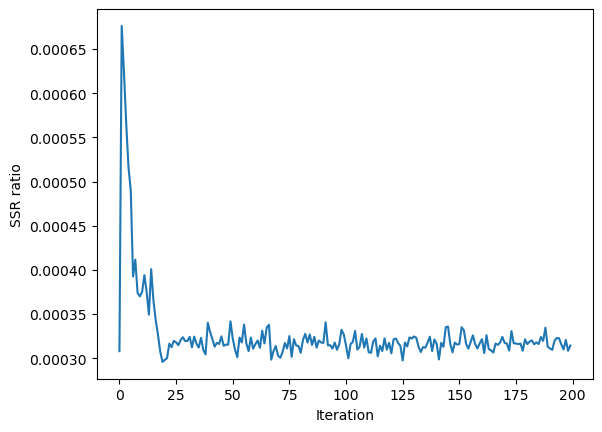

In [13]:
max_SSR_weights = GA_train(X_trading_rule_train, optimizing_selection=2, sol_per_pop=10, num_parents_mating=6, num_generations = 200)

In [14]:
position = (X_trading_rule_train.values[:, 1:]@max_SSR_weights.T).reshape(X_trading_rule_train.shape[0],)
position /= np.max(abs(position))
print('Training data evaluation:')
evaluate(position, X_trading_rule_train.logr)
port_r_train = X_trading_rule_train.logr*position

Training data evaluation:
The maximum position is 1.000, the mean postiion is 0.414823.
The return over the period is: 17.79%
Maximum drawdown is: -0.871%
SR ratio is: 8.175


In [15]:
position = (X_trading_rule_test.values[:, 1:]@max_SSR_weights.T).reshape(X_trading_rule_test.shape[0],)
position /= np.max(abs(position))
print('Testing data evaluation:')
evaluate(position, X_trading_rule_test.logr)
port_r_test = X_trading_rule_test.logr*position

Testing data evaluation:
The maximum position is 0.994, the mean postiion is 0.433992.
The return over the period is: 9.92%
Maximum drawdown is: -0.242%
SR ratio is: 5.605


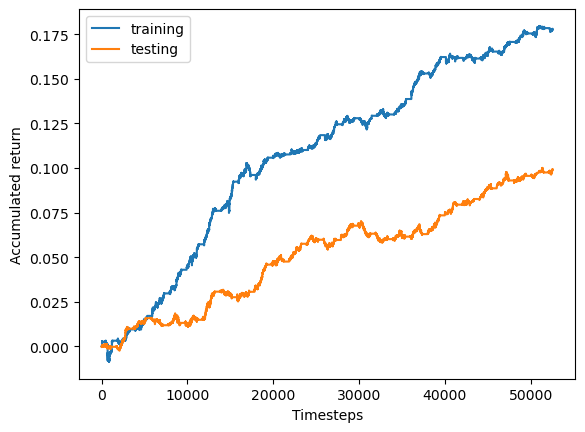

In [16]:
plt.plot(range(len(port_r_train)), port_r_train.cumsum(), label='training')
plt.plot(range(len(port_r_test)), port_r_test.cumsum(), label='testing')
plt.xlabel('Timesteps')
plt.ylabel('Accumulated return')
plt.legend()
plt.show()